In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg

In [ ]:
spark = SparkSession.builder \
    .appName("AverageLikesCommentsPerVideo") \
    .getOrCreate()

In [ ]:
# Read data into a DataFrame
df = spark.read.csv('/content/df_file.csv', header=True, inferSchema=True)
df.head(10)

[Row(videoId='8om1eJrO2lU', videoTitle='RAZR+ Impressions: Is This What You Wanted?', videoPublishedAt='2023-06-01T18:00:42Z', videoLikes='112307', videoViews='4220512', videoCommentCount='6327', all_comments='This is the first phone that id actually be interested in outside of apple, I have bought a last year model  Razr 2023 which has a smaller outside screen and I love it. I thought I will regret it but I&#39;m not. They should make more phones with a smaller outside screen, I personally like this front-screen idea, I am really hyped to see what kinda animated critters people come up with for it. Just seeing what Moto has included themselves has me incredibly excited for it. I think it&#39;s more about personalization than being super useful is what I&#39;m saying., Does anyone know how to move samsung notes (including voice memos) to Motorola??, Yeah 999 no 😢, 8s gen 1 ✅, It&#39;s a pocket mirror 😂, I used to think that flipping/folding phones are just a gimmic. But products like t

In [ ]:
from pyspark.sql.types import IntegerType

df = df.withColumn('videoLikes', df['videoLikes'].cast(IntegerType()))
df = df.withColumn('videoCommentCount', df['videoCommentCount'].cast(IntegerType()))

In [ ]:
df = df.dropDuplicates()

In [ ]:
# Compute averages per video
average_df = df.groupBy('videoTitle').agg(
    avg('videoLikes').alias('average_like_count'),
    avg('videoCommentCount').alias('average_comment_count')
)

In [ ]:
average_df = average_df.dropna(subset=['videoTitle', 'average_like_count', 'average_comment_count'])

In [ ]:
# Show the average like and comment counts per video
average_df.show()

+--------------------+------------------+---------------------+
|          videoTitle|average_like_count|average_comment_count|
+--------------------+------------------+---------------------+
|Apple's Forbidden...|          128764.0|               5878.0|
|Why Everyone is C...|          219172.0|              11551.0|
|iPad Mini 2021 Re...|          170307.0|               8848.0|
|What Happens When...|          157465.0|              10086.0|
|Here's the Thing ...|          116081.0|               5919.0|
|Dope Tech: Booste...|           43826.0|               2532.0|
|RAZR+ Impressions...|          112307.0|               6327.0|
|iPad Air 2020: Th...|          207856.0|              11491.0|
|"iPad Pro M2: Wha...|          109406.0|               3867.0|
|This Smartphone i...|          149270.0|               7485.0|
+--------------------+------------------+---------------------+



In [ ]:
overall_avg = df.agg(
    avg('videoLikes').alias('overall_average_like_count'),
    avg('videoCommentCount').alias('overall_average_comment_count')
)

In [ ]:
# Show the overall averages
overall_avg.show()

+--------------------------+-----------------------------+
|overall_average_like_count|overall_average_comment_count|
+--------------------------+-----------------------------+
|                  141445.4|                       7398.4|
+--------------------------+-----------------------------+



In [ ]:
average_pd_df = average_df.toPandas()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

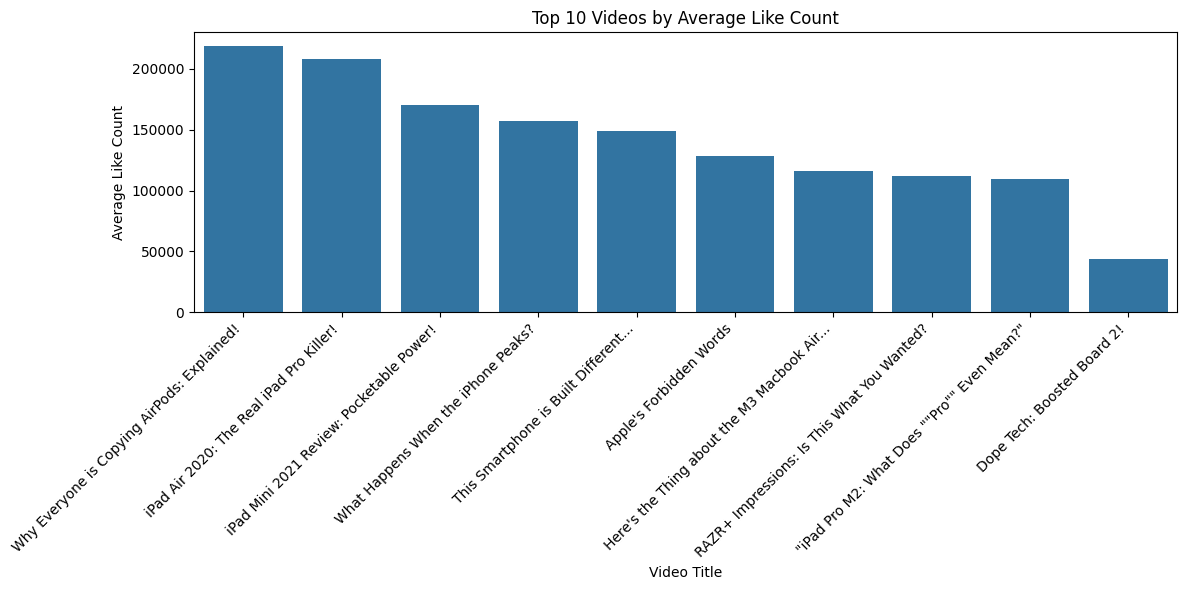

In [ ]:
# Sort the DataFrame by average_like_count in descending order
average_pd_df_sorted = average_pd_df.sort_values('average_like_count', ascending=False)

# Plot the top 10 videos by average likes
plt.figure(figsize=(12, 6))
sns.barplot(
    x='videoTitle',
    y='average_like_count',
    data=average_pd_df_sorted.head(10)
)
plt.title('Top 10 Videos by Average Like Count')
plt.xlabel('Video Title')
plt.ylabel('Average Like Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


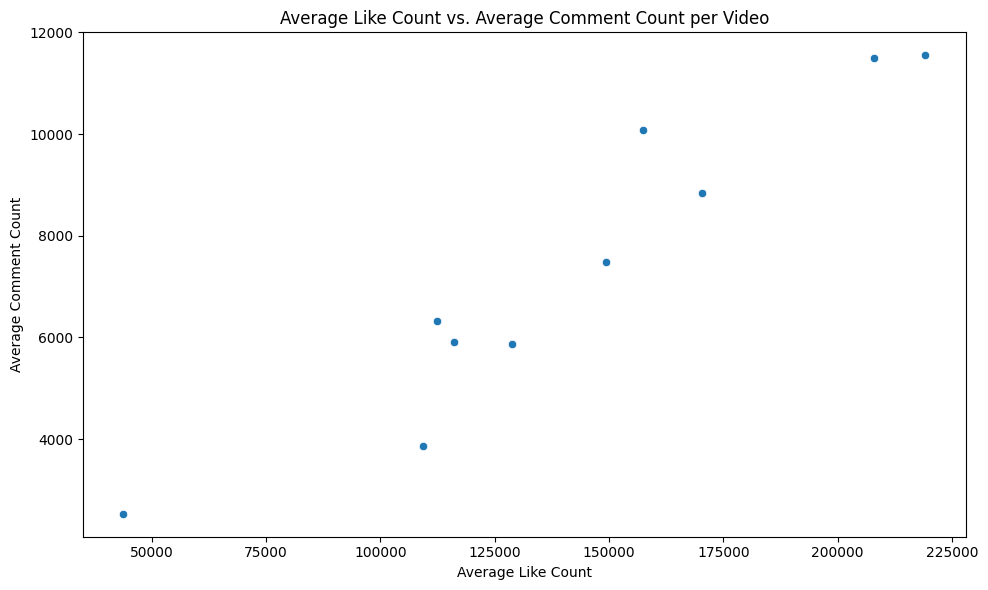

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='average_like_count',
    y='average_comment_count',
    data=average_pd_df
)
plt.title('Average Like Count vs. Average Comment Count per Video')
plt.xlabel('Average Like Count')
plt.ylabel('Average Comment Count')
plt.tight_layout()
plt.show()


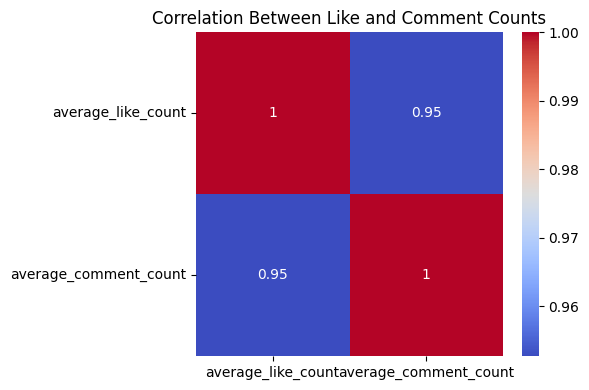

In [ ]:
corr = average_pd_df[['average_like_count', 'average_comment_count']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Like and Comment Counts')
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import col, round
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 50)  # Show more rows if needed
#spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)  # Do not truncate column values
df_with_engagement_rate = df.withColumn(
    "engagement_rate",
    round(((col("videoLikes") + col("videoCommentCount")) / col("videoViews")) * 100, 2)
)

# Step 5: Display Results
df_with_engagement_rate.select("videoTitle", "engagement_rate") \
    .orderBy(col("engagement_rate").desc()) \
    .show(truncate=False)



+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|videoTitle                                                                                                                                 |engagement_rate|
+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|This Smartphone is Built Different...                                                                                                      |4.93           |
|Apple's Forbidden Words                                                                                                                    |4.11           |
|What Happens When the iPhone Peaks?                                                                                                        |3.91           |
|"iPad Pro M2: What Does ""Pro"" Even Mean?"        

In [ ]:
# Stop the SparkSession
spark.stop()